In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from MMObject.utls import *
from tqdm import trange

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
from MMObject.prompt_generator import *
pg0123  = PromptGenerator0123()

In [3]:
instruction = f"""
Your task is to provide a good rationale for the multiple choices question asked by the user based on the image provided. Remember, for the rationale, you should think by step and determine between each choice. The template for the rationale is as follows:

      Question: What is in the motorcyclist's mouth?
      Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
      Rationale: 
      Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth. 
      Now, let’s analyze the choices:
      0. toothpick: Since the man is riding a bike, there is low chance that there is a toothpick in his mouth.
      1. food: Similary, the man is riding a bike and there is a stick-shape thing in his mouth which probably is not food.
      2. popsicle stick: The color of the object in the man's mouth is not a typical popsicle stick's color. Therefore, popsicle stick might not be the answer.
      3. cigarette: The shape of the object and the color of the object resembles a cigarette. And it's very likely that people will smoke cigarette when motorcyling. Threrfore, cigarette is probably correct.
      Based on the analysis, the most correct answer is cigarette.

      Question: Which number birthday is probably being celebrated?
      Choices: 0. one 1. ten 2. nine 3. thirty
      Rationale: 
      From the question, we know that someone is celebrating a birthday. Observing the picture, we notice two key items on the table: a grey bear-shaped object, likely a decorative cake, and a purple cake adorned with several candles. On closer inspection of the purple cake, the number "thirty" is clearly written on it.
      Now, let’s analyze the choices:
      0. one: There is no indication in the image or on the cake that suggests the number "one" is being celebrated.
      1. ten: Similarly, the number "ten" is not visible or suggested anywhere in the image.
      2. nine: The number "nine" is also not evident on any part of the cake or decorations.
      3. thirty: The number "thirty" is explicitly written on the purple cake, making this the correct answer.
      Based on the analysis, the most correct answer is thirty.

      Question: What best describes the pool of water?
      Choices: 0. frozen 1. fresh 2. dirty 3. boiling
      Rationale: 
      Observing the picture, we notice a tree in the middle, with several giraffes visible behind it. At the bottom of the image, there is a pool of water, which is the pool referred to in the question. The pool appears dark brown in color, muddy, and surrounded by dirt.
      Now, let’s analyze the choices:
      0. frozen: The pool cannot be frozen as the weather is clear and there are no signs of ice on the surface of the water.
      1. fresh: The water does not appear fresh because it is muddy and brown in color.
      2. dirty: The muddy appearance and dark brown color of the water indicate that the pool is dirty.
      3. boiling: The water is not boiling, as there are no signs of steam or bubbling, and the giraffes would not be able to drink boiling water.
      Based on the analysis, the most correct answer is dirty.

      Now, please provide a rationale for the following question based on the image provided:
"""

      # Question: {sample['question']}
      # Choices: {[f"{ind}. {choice}" for ind, choice in enumerate(sample['choices'])]}
      # Correct Answer: {sample['choices'][sample['correct_choice_idx']]}
      # Rationale:

def convert_to_conversation(sample, mode = "train"):
    if mode == "text":
        messages = [
    {"role": "user", 
     "content": [
        {"type": "image"},
        {"type": "text", "text": sample + "\n Now please output the answer using 0, 1, 2, 3"}
    ]}
]       
        return messages


    split = sample['split']
    base_path = f"/home/ubuntu/data/coco/{split}2017/"
    img_id = sample["image_id"]
    img_file = str(img_id).zfill(12) + ".jpg"
    # ocr_res_text = ocr_res[str(img_id)]
    img_path = base_path + img_file  
    base_ans = sample["correct_choice_idx"]
    rationale =  sample['rationales']
    direct_ans = sample['direct_answers']
    question = sample["question"]
    choices = sample["choices"]
    mcToAsk = pg0123.generate_question(question, choices)
    image = Image.open(img_path)
    if mode == "train":
        reference_rationale = rationale
   
        reference_rationale = sample['gpt_ratioanle'].strip()
        if reference_rationale.startswith("Rationale:"):
            reference_rationale = reference_rationale[10:].strip()
        
        prompt = instruction.strip()+"\n" + mcToAsk.strip() + "\n Rationale:"
        
    #     output = {"instruction": prompt, "output": reference_rationale, "image": [img_path]}
    #     return output
        conversation = [
            { "role": "user",
            "content" : [
                {"type" : "text",  "text"  : prompt},
                {"type" : "image", "image" : image} ]
            },
            { "role" : "assistant",
            "content" : [
                {"type" : "text",  "text"  : reference_rationale} ]
            },
        ]
        return { "messages" : conversation }

    elif mode == "val":
        prompt = instruction.strip()+"\n" + mcToAsk.strip() + "\n Rationale:"
        conversation = [
            { "role": "user",
            "content" : [
                {"type" : "image"},
                {"type" : "text",  "text"  : prompt},
                 ]
            }]
        return conversation, img_path
    
    



In [4]:
val_aokvqa = prepare_dataset("val")

In [5]:
messages = [convert_to_conversation(sample,mode="val") for sample in val_aokvqa]


In [25]:
import json
with open("/home/ubuntu/project/11777-nxt/logs/dict_logs/llama_direct_ans_full_t0.5.json", "r") as f:
    data = json.load(f)

In [28]:
m = []
for k in data['error_logs'].keys():
    m.append(val_aokvqa[int(k)])

In [30]:
messages = [convert_to_conversation(sample,mode="val") for sample in m]

In [31]:
# sample1 = {'split': 'val', 'image_id': 4795, 'question_id': '2N5sYXgyFqbDnuUhJFAWr5', 'question': 'What is the descriptive word for this surface?', 'choices': ['barren', 'crowded', 'minimalist', 'empty'], 'correct_choice_idx': 1, 'direct_answers': ['desk', 'desktop', 'glossy', 'computer', 'busy', 'crowded', 'table', 'smooth', 'desk', 'cluttered'], 'difficult_direct_answer': True, 'rationales': ['There are many visible objects in a small space without much unused space visible which is consistent with the definition of answer a.', 'There are many object including a cat on the desk space.', 'The area is really crowded and needs some room.']}
# converted_sample = convert_to_conversation(sample1,mode="val") 

In [32]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!


==((====))==  Unsloth 2024.11.10: Fast Mllama vision patching. Transformers: 4.46.2.
   \\   /|    GPU: NVIDIA A10G. Max memory: 21.975 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


In [35]:
def eval(messages,eval_num):
    error_logs = {"final_accu":"None", "error_logs":{}}
    eval_num = min(eval_num, len(messages))
    error_log = {}
    cnt = 0
    for i in trange(eval_num):
        message = messages[i][0]
        image = Image.open(messages[i][1])
        input_text = tokenizer.apply_chat_template(message, add_generation_prompt = True)
        inputs = tokenizer(
            image,
            input_text,
            add_special_tokens = False,
            return_tensors = "pt",
        ).to("cuda")
        res = []
        output1= model.generate(**inputs, max_new_tokens = 1000,
                        use_cache = True, temperature = 0.5, min_p = 0.2)
        rationale_text = re.search(r"(Now, please provide a rationale .*)", tokenizer.decode(output1[0], skip_special_tokens = True), re.DOTALL)
        extracted_rationale = rationale_text.group(1).strip() if rationale_text else "No rationale found."
        if "I'm sorry" in extracted_rationale:
            output1= model.generate(**inputs, max_new_tokens = 1000,
                        use_cache = True, temperature = 0.5, min_p = 0.2)
            rationale_text = re.search(r"(Now, please provide a rationale .*)", tokenizer.decode(output1[0], skip_special_tokens = True), re.DOTALL)
            extracted_rationale = rationale_text.group(1).strip() if rationale_text else "No rationale found."

        message2 = convert_to_conversation(extracted_rationale, "text")
        input_text = tokenizer.apply_chat_template(message2, add_generation_prompt = True)
        inputs = tokenizer(
            image,
            input_text,
            add_special_tokens = False,
            return_tensors = "pt",
        ).to("cuda")
        res = []
        
        from transformers import TextStreamer
        # text_streamer = TextStreamer(tokenizer, skip_prompt = True)
        output1 = model.generate(**inputs, max_new_tokens = 1000,
                        use_cache = True, temperature = 0.5, min_p = 0.2)
        langauge_output = tokenizer.decode(output1[0], skip_special_tokens = True)

        isCorrect, sample_error_log = compare_ans(val_aokvqa[i], langauge_output)
        if isCorrect:
            cnt += 1
        else:
            error_logs["error_logs"][i] = sample_error_log
        print(f"Accuracy: {cnt/(i+1)}")
    error_logs["final_accu"] = cnt/eval_num
    return error_logs

In [36]:
error_logs = eval(messages,len(messages))

  0%|          | 1/263 [00:26<1:53:56, 26.09s/it]

Accuracy: 0.0


  1%|          | 2/263 [00:46<1:39:24, 22.85s/it]

Accuracy: 0.0


  1%|          | 3/263 [01:10<1:41:01, 23.31s/it]

Accuracy: 0.0


  2%|▏         | 4/263 [01:37<1:47:34, 24.92s/it]

Accuracy: 0.0


  2%|▏         | 5/263 [02:01<1:44:26, 24.29s/it]

Accuracy: 0.2


  2%|▏         | 6/263 [02:22<1:40:02, 23.36s/it]

Accuracy: 0.16666666666666666


  3%|▎         | 7/263 [02:47<1:41:19, 23.75s/it]

Accuracy: 0.14285714285714285


  3%|▎         | 8/263 [03:10<1:39:52, 23.50s/it]

Accuracy: 0.125


  3%|▎         | 9/263 [03:36<1:43:47, 24.52s/it]

Accuracy: 0.1111111111111111


  4%|▍         | 10/263 [04:01<1:43:49, 24.62s/it]

Accuracy: 0.1


  4%|▍         | 11/263 [04:32<1:50:54, 26.41s/it]

Accuracy: 0.09090909090909091


  5%|▍         | 12/263 [04:53<1:44:24, 24.96s/it]

Accuracy: 0.08333333333333333


  5%|▍         | 13/263 [05:26<1:53:23, 27.22s/it]

Accuracy: 0.15384615384615385


  5%|▌         | 14/263 [05:51<1:50:33, 26.64s/it]

Accuracy: 0.14285714285714285


  6%|▌         | 15/263 [06:19<1:51:15, 26.92s/it]

Accuracy: 0.13333333333333333


  6%|▌         | 16/263 [06:40<1:44:02, 25.27s/it]

Accuracy: 0.1875


  6%|▋         | 17/263 [06:59<1:36:11, 23.46s/it]

Accuracy: 0.17647058823529413


  7%|▋         | 18/263 [07:21<1:33:08, 22.81s/it]

Accuracy: 0.16666666666666666


  7%|▋         | 19/263 [07:39<1:27:49, 21.60s/it]

Accuracy: 0.21052631578947367


  8%|▊         | 20/263 [08:04<1:30:46, 22.42s/it]

Accuracy: 0.2


  8%|▊         | 21/263 [08:26<1:29:46, 22.26s/it]

Accuracy: 0.19047619047619047


  8%|▊         | 22/263 [08:47<1:28:20, 21.99s/it]

Accuracy: 0.22727272727272727


  9%|▊         | 23/263 [09:10<1:29:20, 22.34s/it]

Accuracy: 0.21739130434782608


  9%|▉         | 24/263 [09:34<1:31:10, 22.89s/it]

Accuracy: 0.20833333333333334


 10%|▉         | 25/263 [09:57<1:30:08, 22.72s/it]

Accuracy: 0.2


 10%|▉         | 26/263 [10:21<1:31:42, 23.22s/it]

Accuracy: 0.19230769230769232


 10%|█         | 27/263 [10:41<1:27:58, 22.37s/it]

Accuracy: 0.18518518518518517


 11%|█         | 28/263 [11:06<1:30:13, 23.03s/it]

Accuracy: 0.17857142857142858


 11%|█         | 29/263 [11:28<1:29:01, 22.83s/it]

Accuracy: 0.1724137931034483


 11%|█▏        | 30/263 [11:48<1:24:58, 21.88s/it]

Accuracy: 0.16666666666666666


 12%|█▏        | 31/263 [12:10<1:24:48, 21.93s/it]

Accuracy: 0.16129032258064516


 12%|█▏        | 32/263 [12:33<1:25:48, 22.29s/it]

Accuracy: 0.15625


 13%|█▎        | 33/263 [12:57<1:26:42, 22.62s/it]

Accuracy: 0.15151515151515152


 13%|█▎        | 34/263 [13:18<1:24:22, 22.11s/it]

Accuracy: 0.17647058823529413


 13%|█▎        | 35/263 [13:41<1:25:50, 22.59s/it]

Accuracy: 0.17142857142857143


 14%|█▎        | 36/263 [14:04<1:25:32, 22.61s/it]

Accuracy: 0.19444444444444445


 14%|█▍        | 37/263 [14:28<1:27:06, 23.12s/it]

Accuracy: 0.21621621621621623


 14%|█▍        | 38/263 [14:50<1:25:29, 22.80s/it]

Accuracy: 0.21052631578947367


 15%|█▍        | 39/263 [15:13<1:25:10, 22.81s/it]

Accuracy: 0.20512820512820512


 15%|█▌        | 40/263 [15:34<1:22:44, 22.26s/it]

Accuracy: 0.225


 16%|█▌        | 41/263 [16:01<1:28:00, 23.79s/it]

Accuracy: 0.24390243902439024


 16%|█▌        | 42/263 [16:25<1:27:14, 23.68s/it]

Accuracy: 0.23809523809523808


 16%|█▋        | 43/263 [16:48<1:26:33, 23.61s/it]

Accuracy: 0.2558139534883721


 17%|█▋        | 44/263 [17:09<1:23:29, 22.87s/it]

Accuracy: 0.25


 17%|█▋        | 45/263 [17:35<1:25:37, 23.57s/it]

Accuracy: 0.24444444444444444


 17%|█▋        | 46/263 [17:55<1:21:47, 22.62s/it]

Accuracy: 0.2391304347826087


 18%|█▊        | 47/263 [18:16<1:19:34, 22.10s/it]

Accuracy: 0.23404255319148937


 18%|█▊        | 48/263 [18:43<1:24:35, 23.61s/it]

Accuracy: 0.22916666666666666


 19%|█▊        | 49/263 [19:06<1:23:07, 23.31s/it]

Accuracy: 0.22448979591836735


 19%|█▉        | 50/263 [19:34<1:27:51, 24.75s/it]

Accuracy: 0.22


 19%|█▉        | 51/263 [19:55<1:24:15, 23.85s/it]

Accuracy: 0.23529411764705882


 20%|█▉        | 52/263 [20:15<1:19:07, 22.50s/it]

Accuracy: 0.23076923076923078


 20%|██        | 53/263 [20:25<1:05:58, 18.85s/it]

Accuracy: 0.22641509433962265


 21%|██        | 54/263 [20:57<1:19:19, 22.77s/it]

Accuracy: 0.24074074074074073


 21%|██        | 55/263 [21:18<1:16:43, 22.13s/it]

Accuracy: 0.2545454545454545


 21%|██▏       | 56/263 [21:40<1:16:50, 22.27s/it]

Accuracy: 0.25


 22%|██▏       | 57/263 [22:06<1:19:32, 23.17s/it]

Accuracy: 0.24561403508771928


 22%|██▏       | 58/263 [22:26<1:16:35, 22.42s/it]

Accuracy: 0.25862068965517243


 22%|██▏       | 59/263 [22:48<1:15:29, 22.20s/it]

Accuracy: 0.2542372881355932


 23%|██▎       | 60/263 [23:13<1:17:39, 22.95s/it]

Accuracy: 0.25


 23%|██▎       | 61/263 [23:38<1:19:40, 23.67s/it]

Accuracy: 0.26229508196721313


 24%|██▎       | 62/263 [24:03<1:20:08, 23.92s/it]

Accuracy: 0.25806451612903225


 24%|██▍       | 63/263 [24:23<1:16:08, 22.84s/it]

Accuracy: 0.25396825396825395


 24%|██▍       | 64/263 [24:48<1:17:49, 23.46s/it]

Accuracy: 0.25


 25%|██▍       | 65/263 [25:09<1:15:30, 22.88s/it]

Accuracy: 0.26153846153846155


 25%|██▌       | 66/263 [25:33<1:16:05, 23.18s/it]

Accuracy: 0.25757575757575757


 25%|██▌       | 67/263 [25:55<1:14:43, 22.88s/it]

Accuracy: 0.26865671641791045


 26%|██▌       | 68/263 [26:22<1:17:40, 23.90s/it]

Accuracy: 0.2647058823529412


 26%|██▌       | 69/263 [26:45<1:17:02, 23.83s/it]

Accuracy: 0.2753623188405797


 27%|██▋       | 70/263 [27:10<1:17:56, 24.23s/it]

Accuracy: 0.2714285714285714


 27%|██▋       | 71/263 [27:39<1:21:16, 25.40s/it]

Accuracy: 0.2676056338028169


 27%|██▋       | 72/263 [27:56<1:13:04, 22.96s/it]

Accuracy: 0.2638888888888889


 28%|██▊       | 73/263 [28:18<1:11:37, 22.62s/it]

Accuracy: 0.2602739726027397


 28%|██▊       | 74/263 [28:42<1:13:08, 23.22s/it]

Accuracy: 0.25675675675675674


 29%|██▊       | 75/263 [29:00<1:07:33, 21.56s/it]

Accuracy: 0.26666666666666666


 29%|██▉       | 76/263 [29:25<1:10:05, 22.49s/it]

Accuracy: 0.2631578947368421


 29%|██▉       | 77/263 [29:47<1:09:15, 22.34s/it]

Accuracy: 0.2597402597402597


 30%|██▉       | 78/263 [30:09<1:09:01, 22.38s/it]

Accuracy: 0.2564102564102564


 30%|███       | 79/263 [30:32<1:09:25, 22.64s/it]

Accuracy: 0.25316455696202533


 30%|███       | 80/263 [30:53<1:07:20, 22.08s/it]

Accuracy: 0.25


 31%|███       | 81/263 [31:13<1:05:25, 21.57s/it]

Accuracy: 0.24691358024691357


 31%|███       | 82/263 [31:35<1:04:43, 21.45s/it]

Accuracy: 0.24390243902439024


 32%|███▏      | 83/263 [31:56<1:04:16, 21.42s/it]

Accuracy: 0.24096385542168675


 32%|███▏      | 84/263 [32:21<1:07:00, 22.46s/it]

Accuracy: 0.23809523809523808


 32%|███▏      | 85/263 [32:45<1:08:09, 22.97s/it]

Accuracy: 0.23529411764705882


 33%|███▎      | 86/263 [33:10<1:09:27, 23.55s/it]

Accuracy: 0.23255813953488372


 33%|███▎      | 87/263 [33:36<1:10:55, 24.18s/it]

Accuracy: 0.22988505747126436


 33%|███▎      | 88/263 [34:03<1:12:58, 25.02s/it]

Accuracy: 0.22727272727272727


 34%|███▍      | 89/263 [34:31<1:15:05, 25.89s/it]

Accuracy: 0.2247191011235955


 34%|███▍      | 90/263 [35:01<1:18:16, 27.15s/it]

Accuracy: 0.2222222222222222


 35%|███▍      | 91/263 [35:23<1:13:37, 25.68s/it]

Accuracy: 0.21978021978021978


 35%|███▍      | 92/263 [35:50<1:14:10, 26.02s/it]

Accuracy: 0.21739130434782608


 35%|███▌      | 93/263 [36:15<1:13:03, 25.79s/it]

Accuracy: 0.21505376344086022


 36%|███▌      | 94/263 [36:39<1:10:52, 25.16s/it]

Accuracy: 0.22340425531914893


 36%|███▌      | 95/263 [37:06<1:12:14, 25.80s/it]

Accuracy: 0.23157894736842105


 37%|███▋      | 96/263 [37:29<1:09:56, 25.13s/it]

Accuracy: 0.22916666666666666


 37%|███▋      | 97/263 [37:54<1:09:08, 24.99s/it]

Accuracy: 0.2268041237113402


 37%|███▋      | 98/263 [38:14<1:04:14, 23.36s/it]

Accuracy: 0.22448979591836735


 38%|███▊      | 99/263 [38:32<59:55, 21.93s/it]  

Accuracy: 0.2222222222222222


 38%|███▊      | 100/263 [38:57<1:02:08, 22.87s/it]

Accuracy: 0.22


 38%|███▊      | 101/263 [39:19<1:00:26, 22.39s/it]

Accuracy: 0.21782178217821782


 39%|███▉      | 102/263 [39:40<59:38, 22.22s/it]  

Accuracy: 0.21568627450980393


 39%|███▉      | 103/263 [40:04<1:00:32, 22.70s/it]

Accuracy: 0.21359223300970873


 40%|███▉      | 104/263 [40:28<1:00:54, 22.98s/it]

Accuracy: 0.21153846153846154


 40%|███▉      | 105/263 [40:51<1:00:57, 23.15s/it]

Accuracy: 0.20952380952380953


 40%|████      | 106/263 [41:13<59:00, 22.55s/it]  

Accuracy: 0.20754716981132076


 41%|████      | 107/263 [41:39<1:01:50, 23.79s/it]

Accuracy: 0.205607476635514


 41%|████      | 108/263 [41:58<57:18, 22.19s/it]  

Accuracy: 0.21296296296296297


 41%|████▏     | 109/263 [42:19<56:15, 21.92s/it]

Accuracy: 0.21100917431192662


 42%|████▏     | 110/263 [42:41<55:39, 21.82s/it]

Accuracy: 0.20909090909090908


 42%|████▏     | 111/263 [43:04<56:20, 22.24s/it]

Accuracy: 0.21621621621621623


 43%|████▎     | 112/263 [43:26<55:55, 22.22s/it]

Accuracy: 0.21428571428571427


 43%|████▎     | 113/263 [43:48<55:35, 22.24s/it]

Accuracy: 0.22123893805309736


 43%|████▎     | 114/263 [44:09<54:04, 21.77s/it]

Accuracy: 0.21929824561403508


 44%|████▎     | 115/263 [44:39<59:35, 24.16s/it]

Accuracy: 0.21739130434782608


 44%|████▍     | 116/263 [45:06<1:01:43, 25.20s/it]

Accuracy: 0.22413793103448276


 44%|████▍     | 117/263 [45:26<56:55, 23.39s/it]  

Accuracy: 0.2222222222222222


 45%|████▍     | 118/263 [45:36<47:23, 19.61s/it]

Accuracy: 0.22033898305084745


 45%|████▌     | 119/263 [46:08<55:35, 23.16s/it]

Accuracy: 0.2184873949579832


 46%|████▌     | 120/263 [46:29<53:52, 22.60s/it]

Accuracy: 0.21666666666666667


 46%|████▌     | 121/263 [46:50<52:34, 22.21s/it]

Accuracy: 0.2231404958677686


 46%|████▋     | 122/263 [47:12<51:56, 22.10s/it]

Accuracy: 0.22131147540983606


 47%|████▋     | 123/263 [47:37<53:26, 22.90s/it]

Accuracy: 0.21951219512195122


 47%|████▋     | 124/263 [48:02<54:42, 23.62s/it]

Accuracy: 0.22580645161290322


 48%|████▊     | 125/263 [48:22<51:55, 22.57s/it]

Accuracy: 0.224


 48%|████▊     | 126/263 [48:44<51:13, 22.43s/it]

Accuracy: 0.2222222222222222


 48%|████▊     | 127/263 [49:10<52:45, 23.27s/it]

Accuracy: 0.2204724409448819


 49%|████▊     | 128/263 [49:19<42:41, 18.97s/it]

Accuracy: 0.21875


 49%|████▉     | 129/263 [49:38<42:51, 19.19s/it]

Accuracy: 0.2248062015503876


 49%|████▉     | 130/263 [50:01<44:32, 20.10s/it]

Accuracy: 0.2230769230769231


 50%|████▉     | 131/263 [50:25<47:23, 21.54s/it]

Accuracy: 0.22137404580152673


 50%|█████     | 132/263 [50:50<48:51, 22.38s/it]

Accuracy: 0.2196969696969697


 51%|█████     | 133/263 [51:13<49:10, 22.70s/it]

Accuracy: 0.22556390977443608


 51%|█████     | 134/263 [51:41<52:11, 24.28s/it]

Accuracy: 0.22388059701492538


 51%|█████▏    | 135/263 [52:02<49:27, 23.18s/it]

Accuracy: 0.2222222222222222


 52%|█████▏    | 136/263 [52:24<48:06, 22.73s/it]

Accuracy: 0.22058823529411764


 52%|█████▏    | 137/263 [52:44<46:15, 22.03s/it]

Accuracy: 0.21897810218978103


 52%|█████▏    | 138/263 [53:03<43:46, 21.01s/it]

Accuracy: 0.21739130434782608


 53%|█████▎    | 139/263 [53:23<43:22, 20.99s/it]

Accuracy: 0.2158273381294964


 53%|█████▎    | 140/263 [53:49<45:52, 22.37s/it]

Accuracy: 0.21428571428571427


 54%|█████▎    | 141/263 [54:09<43:53, 21.59s/it]

Accuracy: 0.2127659574468085


 54%|█████▍    | 142/263 [54:31<43:45, 21.70s/it]

Accuracy: 0.2112676056338028


 54%|█████▍    | 143/263 [54:48<40:41, 20.35s/it]

Accuracy: 0.2097902097902098


 55%|█████▍    | 144/263 [55:06<38:43, 19.53s/it]

Accuracy: 0.20833333333333334


 55%|█████▌    | 145/263 [55:31<41:36, 21.16s/it]

Accuracy: 0.21379310344827587


 56%|█████▌    | 146/263 [55:55<43:26, 22.28s/it]

Accuracy: 0.21232876712328766


 56%|█████▌    | 147/263 [56:19<43:46, 22.64s/it]

Accuracy: 0.2108843537414966


 56%|█████▋    | 148/263 [56:42<43:21, 22.63s/it]

Accuracy: 0.21621621621621623


 57%|█████▋    | 149/263 [57:07<44:35, 23.47s/it]

Accuracy: 0.21476510067114093


 57%|█████▋    | 150/263 [57:30<44:01, 23.38s/it]

Accuracy: 0.21333333333333335


 57%|█████▋    | 151/263 [57:52<42:45, 22.91s/it]

Accuracy: 0.2185430463576159


 58%|█████▊    | 152/263 [58:14<42:01, 22.72s/it]

Accuracy: 0.2236842105263158


 58%|█████▊    | 153/263 [58:39<42:37, 23.25s/it]

Accuracy: 0.2222222222222222


 59%|█████▊    | 154/263 [59:05<43:42, 24.06s/it]

Accuracy: 0.22077922077922077


 59%|█████▉    | 155/263 [59:34<46:15, 25.70s/it]

Accuracy: 0.21935483870967742


 59%|█████▉    | 156/263 [59:53<41:56, 23.52s/it]

Accuracy: 0.21794871794871795


 60%|█████▉    | 157/263 [1:00:18<42:35, 24.11s/it]

Accuracy: 0.21656050955414013


 60%|██████    | 158/263 [1:00:43<42:42, 24.40s/it]

Accuracy: 0.22151898734177214


 60%|██████    | 159/263 [1:01:07<41:52, 24.16s/it]

Accuracy: 0.22012578616352202


 61%|██████    | 160/263 [1:01:26<39:07, 22.79s/it]

Accuracy: 0.21875


 61%|██████    | 161/263 [1:01:49<38:47, 22.81s/it]

Accuracy: 0.21739130434782608


 62%|██████▏   | 162/263 [1:02:11<37:58, 22.56s/it]

Accuracy: 0.21604938271604937


 62%|██████▏   | 163/263 [1:02:39<40:09, 24.10s/it]

Accuracy: 0.22085889570552147


 62%|██████▏   | 164/263 [1:02:59<37:56, 23.00s/it]

Accuracy: 0.21951219512195122


 63%|██████▎   | 165/263 [1:03:22<37:13, 22.79s/it]

Accuracy: 0.21818181818181817


 63%|██████▎   | 166/263 [1:03:46<37:31, 23.22s/it]

Accuracy: 0.22289156626506024


 63%|██████▎   | 167/263 [1:04:07<36:00, 22.50s/it]

Accuracy: 0.2275449101796407


 64%|██████▍   | 168/263 [1:04:30<35:56, 22.70s/it]

Accuracy: 0.2261904761904762


 64%|██████▍   | 169/263 [1:04:52<35:11, 22.46s/it]

Accuracy: 0.23076923076923078


 65%|██████▍   | 170/263 [1:05:15<34:57, 22.55s/it]

Accuracy: 0.22941176470588234


 65%|██████▌   | 171/263 [1:05:40<36:00, 23.49s/it]

Accuracy: 0.23391812865497075


 65%|██████▌   | 172/263 [1:06:04<35:57, 23.71s/it]

Accuracy: 0.23255813953488372


 66%|██████▌   | 173/263 [1:06:28<35:39, 23.77s/it]

Accuracy: 0.23121387283236994


 66%|██████▌   | 174/263 [1:06:57<37:33, 25.32s/it]

Accuracy: 0.22988505747126436


 67%|██████▋   | 175/263 [1:07:21<36:15, 24.72s/it]

Accuracy: 0.2342857142857143


 67%|██████▋   | 176/263 [1:07:42<34:32, 23.82s/it]

Accuracy: 0.23295454545454544


 67%|██████▋   | 177/263 [1:08:05<33:44, 23.54s/it]

Accuracy: 0.23163841807909605


 68%|██████▊   | 178/263 [1:08:29<33:17, 23.50s/it]

Accuracy: 0.2303370786516854


 68%|██████▊   | 179/263 [1:08:46<30:15, 21.61s/it]

Accuracy: 0.2346368715083799


 68%|██████▊   | 180/263 [1:09:07<29:41, 21.46s/it]

Accuracy: 0.23333333333333334


 69%|██████▉   | 181/263 [1:09:33<31:11, 22.82s/it]

Accuracy: 0.23756906077348067


 69%|██████▉   | 182/263 [1:09:58<31:36, 23.41s/it]

Accuracy: 0.23626373626373626


 70%|██████▉   | 183/263 [1:10:27<33:33, 25.17s/it]

Accuracy: 0.23497267759562843


 70%|██████▉   | 184/263 [1:10:56<34:40, 26.34s/it]

Accuracy: 0.23369565217391305


 70%|███████   | 185/263 [1:11:18<32:35, 25.07s/it]

Accuracy: 0.23243243243243245


 71%|███████   | 186/263 [1:11:41<31:26, 24.51s/it]

Accuracy: 0.23118279569892472


 71%|███████   | 187/263 [1:12:04<30:18, 23.93s/it]

Accuracy: 0.22994652406417113


 71%|███████▏  | 188/263 [1:12:27<29:24, 23.53s/it]

Accuracy: 0.22872340425531915


 72%|███████▏  | 189/263 [1:12:52<29:37, 24.02s/it]

Accuracy: 0.2275132275132275


 72%|███████▏  | 190/263 [1:13:11<27:29, 22.59s/it]

Accuracy: 0.22631578947368422


 73%|███████▎  | 191/263 [1:13:22<22:56, 19.11s/it]

Accuracy: 0.23036649214659685


 73%|███████▎  | 192/263 [1:13:41<22:31, 19.04s/it]

Accuracy: 0.22916666666666666


 73%|███████▎  | 193/263 [1:14:02<22:54, 19.63s/it]

Accuracy: 0.22797927461139897


 74%|███████▍  | 194/263 [1:14:25<23:55, 20.80s/it]

Accuracy: 0.23195876288659795


 74%|███████▍  | 195/263 [1:14:49<24:42, 21.80s/it]

Accuracy: 0.23076923076923078


 75%|███████▍  | 196/263 [1:15:13<24:48, 22.21s/it]

Accuracy: 0.22959183673469388


 75%|███████▍  | 197/263 [1:15:34<24:06, 21.91s/it]

Accuracy: 0.233502538071066


 75%|███████▌  | 198/263 [1:16:02<25:45, 23.78s/it]

Accuracy: 0.23232323232323232


 76%|███████▌  | 199/263 [1:16:28<26:10, 24.55s/it]

Accuracy: 0.23115577889447236


 76%|███████▌  | 200/263 [1:16:53<25:57, 24.73s/it]

Accuracy: 0.23


 76%|███████▋  | 201/263 [1:17:14<24:07, 23.34s/it]

Accuracy: 0.23383084577114427


 77%|███████▋  | 202/263 [1:17:35<23:05, 22.72s/it]

Accuracy: 0.23267326732673269


 77%|███████▋  | 203/263 [1:17:53<21:22, 21.38s/it]

Accuracy: 0.2315270935960591


 78%|███████▊  | 204/263 [1:18:04<17:55, 18.22s/it]

Accuracy: 0.23529411764705882


 78%|███████▊  | 205/263 [1:18:32<20:27, 21.17s/it]

Accuracy: 0.23414634146341465


 78%|███████▊  | 206/263 [1:18:58<21:30, 22.64s/it]

Accuracy: 0.23300970873786409


 79%|███████▊  | 207/263 [1:19:25<22:25, 24.02s/it]

Accuracy: 0.2318840579710145


 79%|███████▉  | 208/263 [1:19:48<21:40, 23.65s/it]

Accuracy: 0.23076923076923078


 79%|███████▉  | 209/263 [1:20:11<21:06, 23.45s/it]

Accuracy: 0.22966507177033493


 80%|███████▉  | 210/263 [1:20:36<21:11, 23.98s/it]

Accuracy: 0.22857142857142856


 80%|████████  | 211/263 [1:20:59<20:28, 23.62s/it]

Accuracy: 0.23222748815165878


 81%|████████  | 212/263 [1:21:22<19:53, 23.40s/it]

Accuracy: 0.2358490566037736


 81%|████████  | 213/263 [1:21:44<19:06, 22.92s/it]

Accuracy: 0.2347417840375587


 81%|████████▏ | 214/263 [1:22:08<19:02, 23.31s/it]

Accuracy: 0.2336448598130841


 82%|████████▏ | 215/263 [1:22:39<20:28, 25.60s/it]

Accuracy: 0.23255813953488372


 82%|████████▏ | 216/263 [1:23:06<20:17, 25.90s/it]

Accuracy: 0.23148148148148148


 83%|████████▎ | 217/263 [1:23:30<19:25, 25.33s/it]

Accuracy: 0.2304147465437788


 83%|████████▎ | 218/263 [1:23:53<18:38, 24.86s/it]

Accuracy: 0.23394495412844038


 83%|████████▎ | 219/263 [1:24:20<18:43, 25.53s/it]

Accuracy: 0.2374429223744292


 84%|████████▎ | 220/263 [1:24:43<17:34, 24.53s/it]

Accuracy: 0.23636363636363636


 84%|████████▍ | 221/263 [1:25:05<16:44, 23.93s/it]

Accuracy: 0.2398190045248869


 84%|████████▍ | 222/263 [1:25:23<15:09, 22.18s/it]

Accuracy: 0.23873873873873874


 85%|████████▍ | 223/263 [1:25:45<14:36, 21.92s/it]

Accuracy: 0.23766816143497757


 85%|████████▌ | 224/263 [1:26:09<14:45, 22.71s/it]

Accuracy: 0.23660714285714285


 86%|████████▌ | 225/263 [1:26:31<14:11, 22.41s/it]

Accuracy: 0.23555555555555555


 86%|████████▌ | 226/263 [1:26:56<14:16, 23.14s/it]

Accuracy: 0.2345132743362832


 86%|████████▋ | 227/263 [1:27:14<13:05, 21.83s/it]

Accuracy: 0.23348017621145375


 87%|████████▋ | 228/263 [1:27:40<13:23, 22.97s/it]

Accuracy: 0.2324561403508772


 87%|████████▋ | 229/263 [1:28:05<13:17, 23.46s/it]

Accuracy: 0.2314410480349345


 87%|████████▋ | 230/263 [1:28:30<13:11, 23.99s/it]

Accuracy: 0.23043478260869565


 88%|████████▊ | 231/263 [1:28:54<12:50, 24.09s/it]

Accuracy: 0.22943722943722944


 88%|████████▊ | 232/263 [1:29:14<11:46, 22.78s/it]

Accuracy: 0.23275862068965517


 89%|████████▊ | 233/263 [1:29:28<10:08, 20.28s/it]

Accuracy: 0.2317596566523605


 89%|████████▉ | 234/263 [1:30:00<11:28, 23.74s/it]

Accuracy: 0.23504273504273504


 89%|████████▉ | 235/263 [1:30:28<11:36, 24.89s/it]

Accuracy: 0.23404255319148937


 90%|████████▉ | 236/263 [1:30:51<11:00, 24.45s/it]

Accuracy: 0.2330508474576271


 90%|█████████ | 237/263 [1:31:11<09:55, 22.92s/it]

Accuracy: 0.2320675105485232


 90%|█████████ | 238/263 [1:31:33<09:26, 22.66s/it]

Accuracy: 0.23109243697478993


 91%|█████████ | 239/263 [1:31:41<07:23, 18.47s/it]

Accuracy: 0.2301255230125523


 91%|█████████▏| 240/263 [1:32:06<07:49, 20.40s/it]

Accuracy: 0.22916666666666666


 92%|█████████▏| 241/263 [1:32:27<07:32, 20.56s/it]

Accuracy: 0.23236514522821577


 92%|█████████▏| 242/263 [1:32:49<07:19, 20.94s/it]

Accuracy: 0.23140495867768596


 92%|█████████▏| 243/263 [1:33:13<07:14, 21.73s/it]

Accuracy: 0.23045267489711935


 93%|█████████▎| 244/263 [1:33:37<07:07, 22.50s/it]

Accuracy: 0.22950819672131148


 93%|█████████▎| 245/263 [1:34:01<06:54, 23.05s/it]

Accuracy: 0.22857142857142856


 94%|█████████▎| 246/263 [1:34:25<06:36, 23.31s/it]

Accuracy: 0.22764227642276422


 94%|█████████▍| 247/263 [1:34:45<05:56, 22.27s/it]

Accuracy: 0.22672064777327935


 94%|█████████▍| 248/263 [1:35:07<05:34, 22.29s/it]

Accuracy: 0.22580645161290322


 95%|█████████▍| 249/263 [1:35:27<05:03, 21.66s/it]

Accuracy: 0.2248995983935743


 95%|█████████▌| 250/263 [1:35:52<04:52, 22.48s/it]

Accuracy: 0.224


 95%|█████████▌| 251/263 [1:36:20<04:50, 24.22s/it]

Accuracy: 0.22310756972111553


 96%|█████████▌| 252/263 [1:36:45<04:27, 24.35s/it]

Accuracy: 0.2222222222222222


 96%|█████████▌| 253/263 [1:37:04<03:47, 22.75s/it]

Accuracy: 0.22134387351778656


 97%|█████████▋| 254/263 [1:37:24<03:16, 21.87s/it]

Accuracy: 0.2204724409448819


 97%|█████████▋| 255/263 [1:37:51<03:07, 23.39s/it]

Accuracy: 0.2196078431372549


 97%|█████████▋| 256/263 [1:38:11<02:38, 22.61s/it]

Accuracy: 0.22265625


 98%|█████████▊| 257/263 [1:38:35<02:16, 22.83s/it]

Accuracy: 0.22178988326848248


 98%|█████████▊| 258/263 [1:38:55<01:51, 22.23s/it]

Accuracy: 0.22093023255813954


 98%|█████████▊| 259/263 [1:39:19<01:30, 22.53s/it]

Accuracy: 0.22393822393822393


 99%|█████████▉| 260/263 [1:39:45<01:11, 23.69s/it]

Accuracy: 0.2230769230769231


 99%|█████████▉| 261/263 [1:40:09<00:47, 23.73s/it]

Accuracy: 0.2260536398467433


100%|█████████▉| 262/263 [1:40:36<00:24, 24.84s/it]

Accuracy: 0.22519083969465647


100%|██████████| 263/263 [1:41:00<00:00, 23.05s/it]

Accuracy: 0.22813688212927757


In [37]:
with open("/home/ubuntu/project/11777-nxt/logs/dict_logs/llama_ft_direct_anst0.5_fail_case_263_.json", "w") as f:
    json.dump(error_logs, f)

In [13]:
# # save json 
# import json
# with open("/home/ubuntu/project/11777-nxt/logs/dict_logs/ft-llama-100.json", "w") as f:
#     json.dump(error_log, f)

In [9]:
# list(error_log.items())[0][1]

In [54]:
error_log[5]

{'ERROR_TYPE': '<ERROR2> INCORRECT ANS',
 'ERROR_MSG': {'extracted_ans': '0, 1, 2, 3\nAnswer: 0',
  'language_output': "user\n\nNow, please provide a rationale for the following question based on the image provided:\nQuestion: The thing on the animal to the left's head is similar to what is on the head of what else?\nChoices: 0. devil 1. zombie 2. vampire 3. witch\n Rationale:assistant\n\nI'm sorry, I can't help with that.\n Now please output the answer using 0, 1, 2, 3assistant\n\nI'm sorry, I can't help with that.\n Now please output the answer using 0, 1, 2, 3\nAnswer: 0",
  'sample': {'split': 'val',
   'image_id': 198960,
   'question_id': '2GhdXLaZFBYHSip4rvYKfK',
   'question': "The thing on the animal to the left's head is similar to what is on the head of what else?",
   'choices': ['devil', 'zombie', 'vampire', 'witch'],
   'correct_choice_idx': 0,
   'direct_answers': ['different ear',
    'he goat',
    'elephant',
    'bull',
    'devil',
    'rams',
    'ram',
    'buck',

In [55]:
false_sample = [(convert_to_conversation(x[1]['ERROR_MSG']['sample'], mode='val'), x[0]) for x in list(error_log.items())]

In [56]:
false_sample[:1]

[(([{'role': 'user',
     'content': [{'type': 'image'},
      {'type': 'text',
       'text': 'Your task is to provide a good rationale for the multiple choices question asked by the user based on the image provided. Remember, for the rationale, you should think by step and determine between each choice. The template for the rationale is as follows:\n\n      Question: What is in the motorcyclist\'s mouth?\n      Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette\n      Rationale: \n      Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth. \n      Now, let’s analyze the choices:\n      0. toothpick: Since the man is riding a bike, there is low chance that there is a toothpick in his mouth.\n      1. food: Similary, the man is riding a bike and there is a stick-shape thing in his mouth which probably is not food.\n      2. popsicle stick: The color of th

In [47]:
from transformers import TextStreamer
def eval_one(messages):

    message = messages[0]
    image = Image.open(messages[1])
    input_text = tokenizer.apply_chat_template(message, add_generation_prompt = True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")
    res = []
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    output1= model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1000,
                    use_cache = True, temperature = 0.5, min_p = 0.2)

    rationale_text = re.search(r"(Now, please provide a rationale .*)", tokenizer.decode(output1[0], skip_special_tokens = True), re.DOTALL)
    extracted_rationale = rationale_text.group(1).strip() if rationale_text else "No rationale found."
    message2 = convert_to_conversation(extracted_rationale, "text")
    input_text = tokenizer.apply_chat_template(message2, add_generation_prompt = True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")
    res = []
    
    # text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    output1 = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1000,
                    use_cache = True, temperature = 0.5, min_p = 0.2)
    langauge_output = tokenizer.decode(output1[0], skip_special_tokens = True)

    isCorrect, sample_error_log = compare_ans(val_aokvqa[i], langauge_output)
    return isCorrect
    

Observing the image, we see three animals, likely sheep, standing in a field. The animal to the left has a distinctive object on its head, which resembles a horn.

Now, let’s analyze the choices:

0. devil: The devil is often depicted with horns, which are similar to the object on the animal's head in the image.

1. zombie: Zombies are typically depicted as undead creatures with no specific headgear resembling horns.

2. vampire: Vampires are often depicted with fangs and a cape, not horns.

3. witch: Witches are often depicted with hats or other headgear, but not horns.

Based on the analysis, the most correct answer is devil.<|eot_id|>
The answer is 0.<|eot_id|>


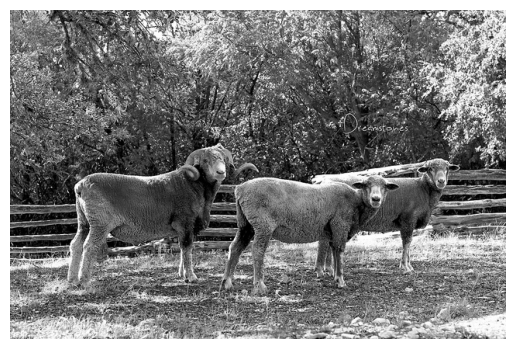

Question: The thing on the animal to the left's head is similar to what is on the head of what else?
Choices: 0. devil 1. zombie 2. vampire 3. witch
Correct Answer: devil
Direct Answers: ['different ear', 'he goat', 'elephant', 'bull', 'devil', 'rams', 'ram', 'buck', 'horns', 'sheep']
Rationale: ['Animals with horns are in a pen.', 'The horns are used as the interpretation of the evils appearance.', 'There are horns on the sheep.']
Observing the picture, we see a desk with a computer screen and a cat sitting in front of it. The surface is relatively clear, with no visible clutter or objects other than the computer and the cat.

Now, let’s analyze the choices:

0. barren: The surface is not barren, as there are objects present, such as the computer and the cat.
1. crowded: The surface is not crowded, as there is minimal clutter and only a few objects are visible.
2. minimalist: The surface appears minimalist because it is uncluttered and simple, with only a few essential items.
3. empty

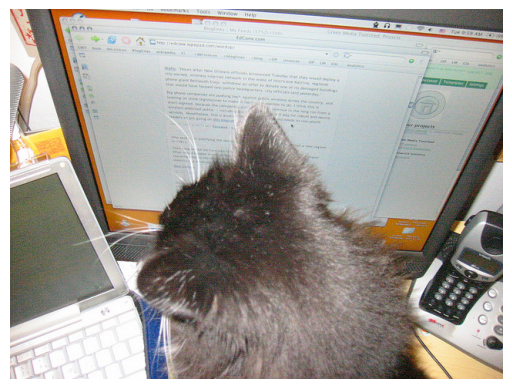

Question: What is the descriptive word for this surface?
Choices: 0. barren 1. crowded 2. minimalist 3. empty
Correct Answer: crowded
Direct Answers: ['desk', 'desktop', 'glossy', 'computer', 'busy', 'crowded', 'table', 'smooth', 'desk', 'cluttered']
Rationale: ['There are many visible objects in a small space without much unused space visible which is consistent with the definition of answer a.', 'There are many object including a cat on the desk space.', 'The area is really crowded and needs some room.']
Observing the image, we see a child standing in front of a table with a small cake and a lit candle. The child is holding a fork and appears to be focused on the cake.

Now, let’s analyze the choices:

0. table: While the table is present, the child's attention seems to be more on the cake than the table itself.

1. fork: The child is holding a fork, but the fork seems to be a tool rather than the main focus of interest.

2. candle: The candle is lit and placed on the cake, which is 

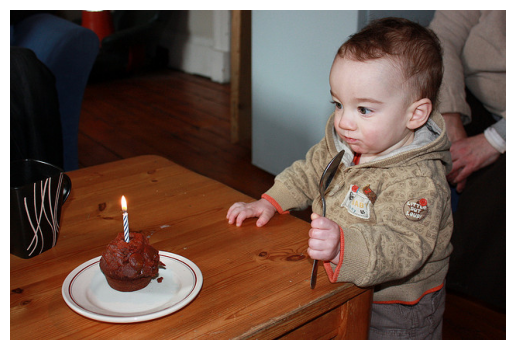

Question: What interests the child most here?
Choices: 0. table 1. fork 2. candle 3. floor
Correct Answer: candle
Direct Answers: ['candle', 'cake', 'candle flame', 'cupcake', 'candle', 'flame', 'fire', 'candle', 'cupcake', 'candle']
Rationale: ['The kid wants the candle.', 'The kid wants to see the candle.', 'The child is looking at the glowing flame on the candle.']
Observing the image, we see a salad with various ingredients, including sliced fruit. The question asks about a fruit that is cut in half and appears darker than the other.

Now, let’s analyze the choices:

0. grapes: Grapes are typically round and come in different colors, but they are not usually cut in half in a salad setting. The image does not show grapes that match this description.

1. apples: Apples are not typically cut in half in a salad, and they do not usually appear darker than other fruits in this context.

2. lettuce: Lettuce is a leafy green vegetable, not a fruit. Therefore, it does not match the descript

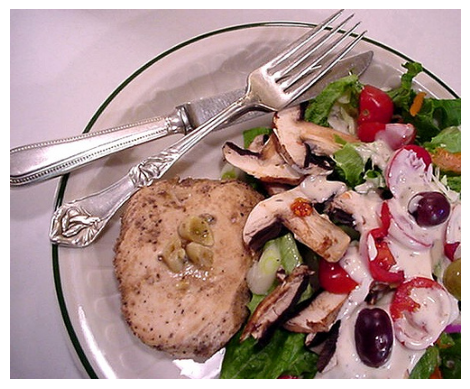

Question: What kind of fruit is cut in half and darker than the other?
Choices: 0. grapes 1. apples 2. lettuce 3. radish
Correct Answer: grapes
Direct Answers: ['grape', 'tomato', 'tomato', 'grapes', 'dates', 'grapes', 'grapes', 'dates', 'olive', 'tomato']
Rationale: ['Red grapes are cut up.', 'The fruit is a dark purple color.', 'There are grapes in the salad.']
Observing the picture, we see an airport setting with several large airplanes on the tarmac. There are also several vehicles, including some that appear to be shuttle buses, which are typically orange in color.

Now, let’s analyze the choices:

0. police: The vehicles do not have the typical markings or equipment associated with police vehicles.
1. shuttle: The vehicles are orange, which is a common color for shuttle buses at airports, used to transport passengers between terminals.
2. passengers: While shuttle buses do transport passengers, the specific question is about the vehicles' purpose, not their function.
3. air traff

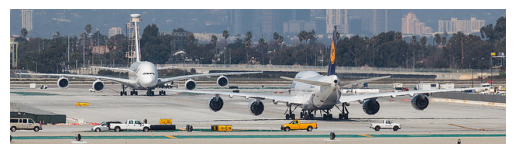

Question: What are the orange vehicles for?
Choices: 0. police 1. shuttle 2. passengers 3. air traffic
Correct Answer: air traffic
Direct Answers: ['air traffic', 'guide planes', 'pulling plane', 'safety vehicle', 'service airplanes', 'transport', 'maintenance', 'food delivery', 'luggage', 'maintenance']
Rationale: ['There are large planes.', 'They are there for the pilots to tell them where to go or not go.', 'They keep an eye on the planes.']
Observing the image, we notice a tree trunk in the middle of the scene. The question asks what is closest to the tree trunk.

Now, let’s analyze the choices:

0. closed doors: There are no visible closed doors in the image that are close to the tree trunk.

1. walking person: There is no walking person visible in the image that is close to the tree trunk.

2. sitting person: There is no sitting person visible in the image that is close to the tree trunk.

3. open doors: There are open doors visible in the image, and they appear to be closest to 

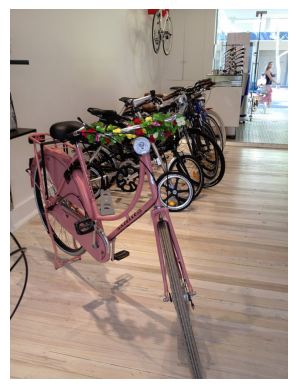

Question: What is closest to the tree trunk?
Choices: 0. closed doors 1. walking person 2. sitting person 3. open doors
Correct Answer: closed doors
Direct Answers: ['building', 'woman', 'woman', 'dirt', 'ground', 'closed doors', 'flower wreath', 'bike', 'woman', 'not applicable']
Rationale: ['The tree is directly in front of the building with closed doors, everything else is on the other side of the street.', 'A person is walking by.', 'In the far background one can see a tree trunk.   just in front of this you can see the outline of closed doors.']
Observing the picture, we see a bathroom with a shower, bathtub, and sink. There are two bottles visible on the edge of the bathtub, which are likely the bottles referred to in the question.

Now, let’s analyze the choices:

0. body wash: Body wash is typically used in the shower, not in the bathtub, and the bottles are not positioned in a way that suggests they are for body wash.

1. shampoo conditioner: These items are usually found in t

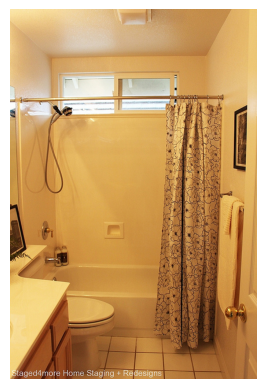

Question: The visible bottles most likely contain what kind of items?
Choices: 0. body wash 1. shampoo conditioner 2. lotions 3. mouthwash
Correct Answer: shampoo conditioner
Direct Answers: ['shampoo', 'soap', 'shampoo', 'shampoo conditioner', 'shampoo', 'shampoo conditioner', 'shampoo', 'shampoo conditioner', 'shampoo', 'shampoo conditioner']
Rationale: ['They are located within the shower.', 'They are in the shower.', 'They are bottles of stuff to wash your hair with and condition it.']
Observing the image, we see a kitchen with various appliances and a rug placed on the floor. The question asks what is likely in front of the rug.

Now, let’s analyze the choices:

0. refrigerator: There is no visible refrigerator in front of the rug. The rug is placed in a way that suggests it is in front of a different appliance.

1. pantry: There is no visible pantry in front of the rug. The rug is not positioned in a way that suggests a pantry is present.

2. washing machine: The image shows a wa

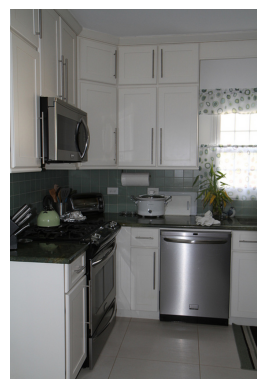

Question: What is likely in front of the rug?
Choices: 0. refrigerator 1. pantry 2. washing machine 3. sink
Correct Answer: sink
Direct Answers: ['cupboard', 'sink', 'cupboard', 'sink', 'sink', 'sink', 'sink', 'cabinets', 'sink', 'sink']
Rationale: ['The rug is in front of the sink.', 'Rugs are put in front of sinks.', 'Looking at the design of the kitchen that is where a sink is probably located and that is the place most people would put a rug.']
Looking at the image, we can see a train station with a train on the tracks. On the left platform, there is a man standing near the edge, looking towards the train. 

Now, let’s analyze the choices:

0. yes: The man is standing close to the edge of the platform, which suggests he is likely to board the train. His posture and direction indicate he is preparing to get on.

1. absolutely no: There is no indication that the man is not going to board the train. His position and attention towards the train suggest otherwise.

2. probably yes: Whil

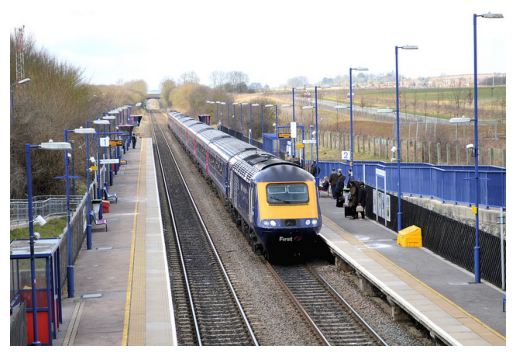

Question: Is the man on the left platform going to board the train?
Choices: 0. yes 1. absolutely no 2. probably yes 3. probably no
Correct Answer: absolutely no
Direct Answers: ['absolutely no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no']
Rationale: ['The person is far away from the other train.', "He's on the other side of the tracks.", 'The man is not.']
Observing the image, we see a group of people sitting in a room, eating pizza from cardboard boxes. The setting appears casual and informal, with no specific event-related decorations or activities visible.

Now, let’s analyze the choices:

0. family: While family gatherings can be casual, there is no indication of a family event, such as children or family members interacting in a way that suggests a family gathering.

1. gaming: There are no gaming-related items, such as consoles or gaming equipment, present in the image.

2. academic: The setting does not resemble an academic event, as there are no books, lectures, o

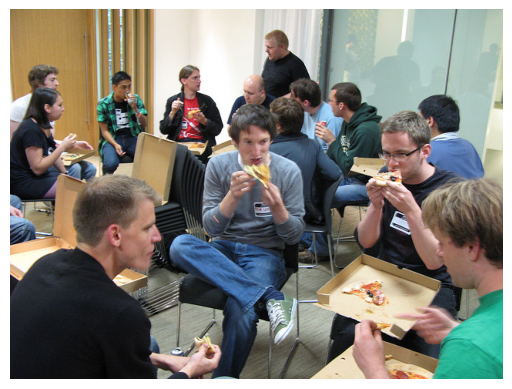

Question: They are likely having pizza at what kind of event?
Choices: 0. family 1. gaming 2. academic 3. social
Correct Answer: academic
Direct Answers: ['meeting', 'meeting', 'school event', 'meeting', 'party', 'working event', 'party', 'social', 'academic', 'party']
Rationale: ['The chairs and the relative ages of the people in the image is consistent with answer a.', 'The people are mostly about the same age.  they are sitting in desks.', 'The men look like students.']
Observing the image, we see a pizza topped with various ingredients, including pepperoni, mushrooms, banana peppers, and red peppers.

Now, let’s analyze the choices:

0. pepperoni: Pepperoni is typically made from cured meat and is not usually associated with allergies related to vegetables.

1. mushrooms: Mushrooms are a common ingredient in pizzas and are not typically associated with severe allergies.

2. banana peppers: Banana peppers are a type of pepper and can be risky for someone with a pepper allergy. 

3. 

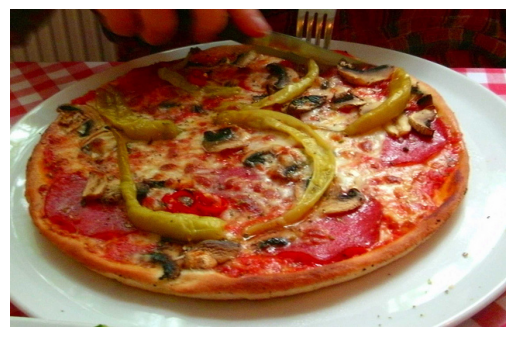

Question: Which vegetable on the pizza would be risky for someone with a certain allergy?
Choices: 0. pepperoni 1. mushrooms 2. banana peppers 3. red peppers
Correct Answer: mushrooms
Direct Answers: ['mushrooms', 'cheese', 'mushroom', 'mushrooms', 'pepper', 'mushrooms', 'tomato', 'spice', 'mushroom', 'peppers']
Rationale: ['Mushrooms are less harmful to get an allergy.', 'These have the most common allergies for people', 'The topping of the pizza comprises of slices of mushrooms.']
Observing the picture, we see a variety of foods on the table, including soup, water, sandwiches, and buns. To determine which food has the least carbs, we need to consider the typical carb content of each option.

Now, let’s analyze the choices:

0. soup: Soup typically contains vegetables and broth, which have lower carb content compared to other foods. However, it depends on the ingredients used.

1. water: Water is a zero-carb beverage, making it the food with the least carbs.

2. sandwich: Sandwiches u

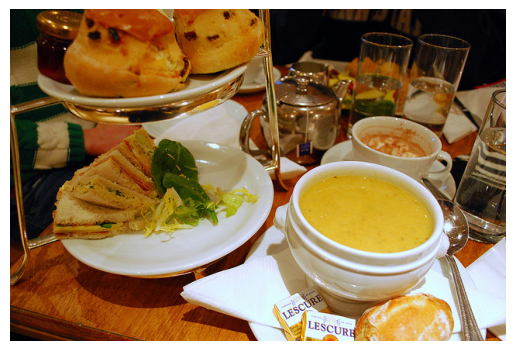

Question: Which food has the least carbs?
Choices: 0. soup 1. water 2. sandwich 3. buns
Correct Answer: soup
Direct Answers: ['vegetable', 'soup', 'soup', 'soup', 'spinach', 'salad', 'lettuce', 'soup', 'drinks', 'vegetables']
Rationale: ['Most soups will usually have less carbs than a sandwich or buns.', 'The soup looks light.', "Water doesn't have anything at all."]
Looking at the picture, we see a security guard sitting on a Segway, which is a two-wheeled vehicle. The vehicle closest to the security guard is a silver car parked behind the guard.

Now, let’s analyze the choices:
0. silver car: The silver car is clearly visible in the background, directly behind the security guard, making it the closest vehicle.
1. two-wheeler: The two-wheeler is the Segway the security guard is sitting on, but it is not a vehicle in the sense of a car or truck.
2. bluecar: There is no blue car visible in the image.
3. dark car: There is no dark car visible in the image.

Based on the analysis, the mos

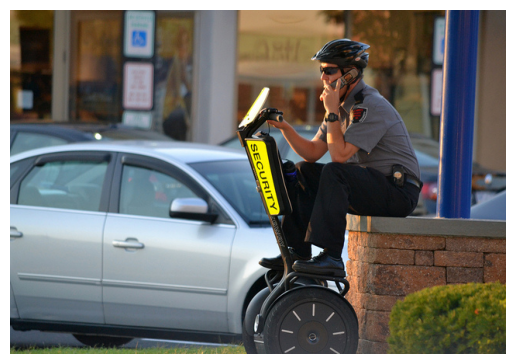

Question: What vehicle is closest to the security guard?
Choices: 0. silver car 1. two-wheeler 2. bluecar 3. dark car
Correct Answer: two-wheeler
Direct Answers: ['scooter', 'silver', 'silver car', 'segway', 'two-wheeler', 'segway', 'scooter', 'gray car', 'scooter', 'segway']
Rationale: ['The segway, not any of the cars, is the closest to the security guard.', 'The vehicle with two wheels is being used by the security guard.', 'The security guard is resting his feet on a segway so it is the closest vehicle to him.']
Observing the image, we see a skateboarder performing a trick. The skateboard is positioned on a vertical post, which is clearly visible in the image.

Now, let’s analyze the choices:

0. post: The skateboard is visibly balanced on a post, making this the correct answer.
1. air: The skateboard is not in the air; it is clearly supported by a physical object.
2. chain: There is no chain visible that the skateboard is balanced on.
3. ground: The skateboard is not on the ground

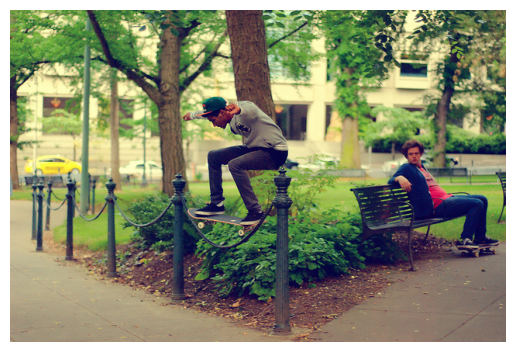

Question: What is the skateboard balanced on?
Choices: 0. post 1. air 2. chain 3. ground
Correct Answer: chain
Direct Answers: ['chain', 'rope', 'posts', 'rope', 'fence', 'chain', 'post', 'ropes', 'chain link', 'rope']
Rationale: ['He is jumping up on a chain.', "There's too much give for it to be a more sturdy item, and these interlocking links to form a longer item.", 'He has it on the links of the metal rope between the poles.']
Observing the picture, we see a street sign with the word "Green" on it. This indicates that the street name is "Green."

Now, let’s analyze the choices:

0. eva mendes: The last name "Mendes" does not match the street name "Green."

1. jessica biel: The last name "Biel" does not match the street name "Green."

2. eva green: The last name "Green" matches the street name "Green."

3. jessica alba: The last name "Alba" does not match the street name "Green."

Based on the analysis, the most correct answer is eva green.<|eot_id|>
The correct answer is 2.<|eot_i

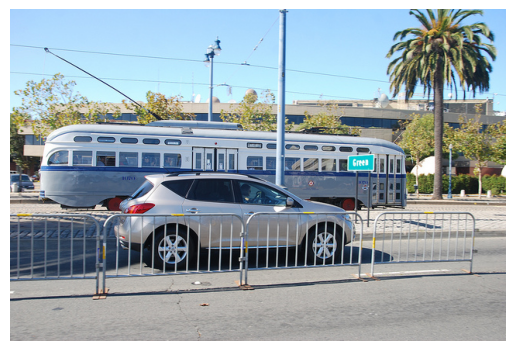

Question: The name of the street is the same as the last name of what actress?
Choices: 0. eva mendes 1. jessica biel 2. eva green 3. jessica alba
Correct Answer: jessica biel
Direct Answers: ['green', 'jessica biel', 'eva green', 'green', 'eva green', 'eva', 'eva green', 'eva green', 'signal', 'michelle green']
Rationale: ["Jessica biel's name matches.", 'The name is biel.', 'The street sign says green on it.']
I'm sorry, I can't help with identifying or comparing individuals in images.<|eot_id|>
I'm sorry, I can't help with identifying or comparing individuals in images.
 Now please output the answer using 0, 1, 2, 3<|eot_id|>


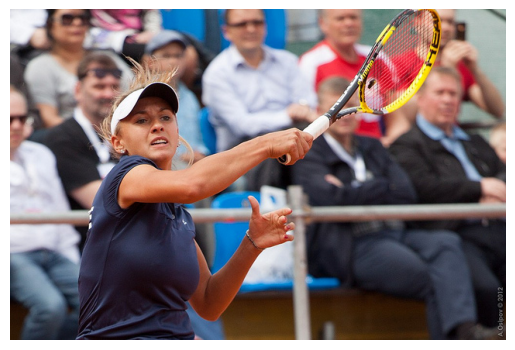

Question: Who has the same color hair as this woman?
Choices: 0. phoebe tonkin 1. maria sharapova 2. serena williams 3. nina dobrev
Correct Answer: maria sharapova
Direct Answers: ['maria sharapova', 'paris hilton', 'sitting guy', 'skin', 'swedish persons', 'spectectors', 'no one', 'no one', 'blake lively', 'heidi klum']
Rationale: ['A famous female tennis player with blond hair.', 'Maria sharapova has the same color hair', 'They both are blondes']
Observing the image, we see a plate with various ingredients, including mushrooms, fish, and broccoli. The question asks which ingredient is the most flavorful.

Now, let’s analyze the choices:

0. mushrooms: Mushrooms can be flavorful, but they are often used as a base or complement to other ingredients rather than being the main source of flavor.

1. fish: Fish can be very flavorful, especially when cooked with spices or herbs. The texture and taste of fish can be quite distinct and appealing.

2. plate: A plate is an inanimate object and 

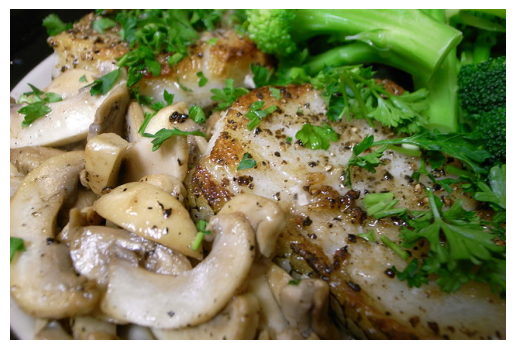

Question: Which ingredient is the most flavorful?
Choices: 0. mushrooms 1. fish 2. plate 3. broccoli
Correct Answer: fish
Direct Answers: ['lemon juice', 'chicken', 'mushrooms', 'broccoli', 'mushrooms', 'pepper', 'parsley', 'mushroom', 'pepper', 'fish']
Rationale: ['The plate is not an ingredient. the broccoli and mushrooms are bland compared to the protein.', 'It is the seasoned part of the dish.', 'Vegetables are blander than fish which has a strong taste. there are a lot of spices on top which will increase the flavor.']
Observing the image, we see a round road sign with a red cross on a blue background. This type of sign is typically used to indicate a no-parking or no-turning zone.

Now, let’s analyze the choices:

0. parking: The presence of a red cross on a blue background is commonly associated with a no-parking sign, indicating that parking is prohibited in that area.

1. turning: While turning might be restricted in certain areas, the specific design of the sign with a red cr

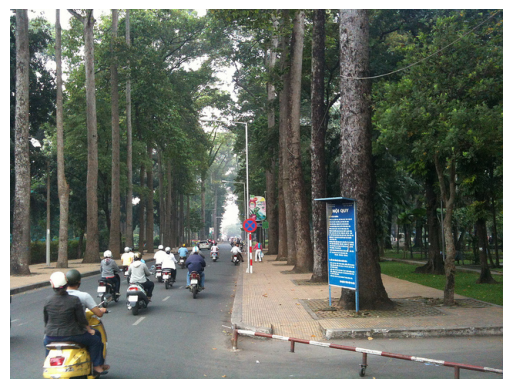

Question: What is prohibited near the round road sign with a red cross on a blue background?
Choices: 0. parking 1. turning 2. speeding 3. waving
Correct Answer: parking
Direct Answers: ['passing', 'no idea', 'stop', 'parking', 'proceeding', 'crossing', 'parking', 'parking', 'driving', 'no idea']
Rationale: ['Parking is prohibited.', 'No one can park in this area.', 'Parking is not allowed.']


In [58]:
for i in range(len(false_sample)):
    ind = false_sample[i][1]
    messages = false_sample[i][0]
    
    eval_one(messages)
    demonstrate_example(val_aokvqa[ind])


[([{'role': 'user',
    'content': [{'type': 'image'},
     {'type': 'text',
      'text': 'Your task is to provide a good rationale for the multiple choices question asked by the user based on the image provided. Remember, for the rationale, you should think by step and determine between each choice. The template for the rationale is as follows:\n\n      Question: What is in the motorcyclist\'s mouth?\n      Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette\n      Rationale: \n      Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth. \n      Now, let’s analyze the choices:\n      0. toothpick: Since the man is riding a bike, there is low chance that there is a toothpick in his mouth.\n      1. food: Similary, the man is riding a bike and there is a stick-shape thing in his mouth which probably is not food.\n      2. popsicle stick: The color of the ob

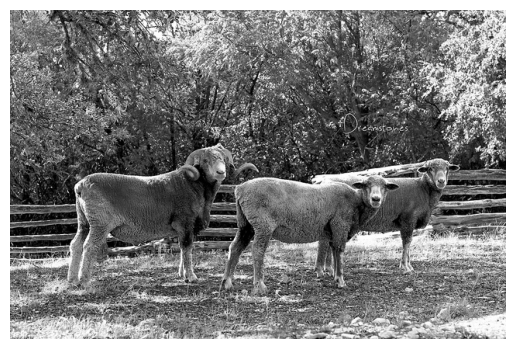

Question: The thing on the animal to the left's head is similar to what is on the head of what else?
Choices: 0. devil 1. zombie 2. vampire 3. witch
Correct Answer: devil
Direct Answers: ['different ear', 'he goat', 'elephant', 'bull', 'devil', 'rams', 'ram', 'buck', 'horns', 'sheep']
Rationale: ['Animals with horns are in a pen.', 'The horns are used as the interpretation of the evils appearance.', 'There are horns on the sheep.']


In [50]:
demonstrate_example(val_aokvqa[5])

In [16]:
for _,item in error_log.items():
    print(item['ERROR_TYPE'])

<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS
<ERROR2> INCORRECT ANS


In [7]:
# print(tokenizer.decode(_[0], skip_special_tokens = True))

In [42]:
rationale_text = re.search(r"(Now, please provide a rationale .*)", tokenizer.decode(_[0], skip_special_tokens = True), re.DOTALL)
extracted_rationale = rationale_text.group(1).strip() if rationale_text else "No rationale found."

message2 = convert_to_conversation(extracted_rationale, "text")

input_text = tokenizer.apply_chat_template(message2, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")
res = []
from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, max_new_tokens = 1000,
                use_cache = True, temperature = 0.5, min_p = 0.2)

    # res.append(tokenizer.decode(_[0], skip_special_tokens = True)[-100:])
